In [529]:
%load_ext autoreload
%autoreload 2
import os
import pickle as pkl
import itertools
from functools import partial
from os.path import join as oj
from collections import defaultdict
import warnings

warnings.filterwarnings(action="ignore", category=UserWarning)

import imodels
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imodels.util import data_util
from numpy import concatenate as npcat
from tqdm import tqdm
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn import metrics, model_selection
from sklearn.neighbors import KernelDensity
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)
mpl.rcParams['figure.dpi'] = 250
np.random.seed(0)

# change working directory to project root
while os.getcwd().split('/')[-1] != 'imodels-experiments':
    os.chdir('..')

import viz
import validate

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [530]:
DATASET = 'iai'
SPLIT_SEED = 12
RESULT_PATH = f'notebooks/transfertree/results/{DATASET}__/seed_{SPLIT_SEED}'
if not os.path.exists(RESULT_PATH):
    os.makedirs(RESULT_PATH)

In [531]:
def all_stats_curve(y_test, preds_proba, plot=False, thresholds=None, model_name=None):
    '''preds_proba should be 1d
    '''
    if thresholds is None:
        thresholds = sorted(np.unique(preds_proba))
    all_stats = {
        s: [] for s in ['sens', 'spec', 'ppv', 'npv', 'lr+', 'lr-', 'f1']
    }
    for threshold in tqdm(thresholds):
        preds = preds_proba > threshold
        tn, fp, fn, tp = metrics.confusion_matrix(y_test, preds).ravel()
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            sens = tp / (tp + fn)
            spec = tn / (tn + fp)
            all_stats['sens'].append(sens)
            all_stats['spec'].append(spec)
            all_stats['ppv'].append(tp / (tp + fp))
            all_stats['npv'].append(tn / (tn + fn))
            all_stats['lr+'].append(sens / (1 - spec))
            all_stats['lr-'].append((1 - sens) / spec)
            all_stats['f1'].append(tp / (tp + 0.5 * (fp + fn)))

    if plot:
        if 'pecarn' in model_name.lower():
            plt.plot(all_stats['sens'][0], all_stats['spec'][0], '.-', label=model_name)
        else:
            plt.plot(all_stats['sens'], all_stats['spec'], '.-', label=model_name)
        plt.xlabel('sensitivity')
        plt.ylabel('specificity')
        plt.grid()
    return all_stats, thresholds

In [532]:
results = defaultdict(lambda:[])
columns = [f'spec9{i}' for i in range(0, 9, 2)] + ['aps', 'auc', 'acc', 'f1', 'args']

def log_results(model, model_name, X_test, y_test, model_args=None, dct=None):
    pred_proba_args = (X_test,)
    
    spec_scorer_list = [validate.make_best_spec_high_sens_scorer(sens) for sens in [0.9, 0.92, 0.94, 0.96, 0.98]]
    spec_scores = [scorer(y_test, model.predict_proba(*pred_proba_args)[:, 1]) for scorer in spec_scorer_list]
    apc = metrics.average_precision_score(y_test, model.predict_proba(*pred_proba_args)[:, 1])
    auc = metrics.roc_auc_score(y_test, model.predict_proba(*pred_proba_args)[:, 1])
    acc = metrics.accuracy_score(y_test, model.predict(X_test))
    f1 = metrics.f1_score(y_test, model.predict(X_test))
    if dct is not None:
        dct[model_name] = spec_scores + [apc, auc, acc, f1, model_args]
    else:
        results[model_name] = spec_scores + [apc, auc, acc, f1, model_args]

In [533]:
class TransferTree:
    def __init__(self, model_0, model_1, model_1_log_arr):
        self.model_0 = model_0
        self.model_1 = model_1
        self.model_1_log_arr = model_1_log_arr

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

    def predict_proba(self, X):
        preds_proba = np.zeros((X.shape[0], 2))
        preds_proba[~self.model_1_log_arr] = self.model_0.predict_proba(
            X[~self.model_1_log_arr])
        preds_proba[self.model_1_log_arr] = self.model_1.predict_proba(
            X[self.model_1_log_arr])
        return preds_proba

class PECARNModel:
    def __init__(self, young):
        self.young = young

    def predict(self, X: pd.DataFrame):
        if DATASET == 'tbi' and self.young:
            factors_sum = (
                X['AMS'] + X['HemaLoc_Occipital'] + X['HemaLoc_Parietal/Temporal'] + X['LocLen_1-5 min'] + 
                X['LocLen_5 sec - 1 min'] + X['LocLen_>5 min'] + X['High_impact_InjSev_High'] + 
                X['SFxPalp_Unclear'] + X['SFxPalp_Yes'] + (1 - X['ActNorm']))
        elif DATASET == 'tbi':
            factors_sum = (
                X['AMS'] + X['Vomit'] + X['LOCSeparate_Suspected'] + X['LOCSeparate_Yes'] + 
                X['High_impact_InjSev_High'] + X['SFxBas'] +  X['HASeverity_Severe'])
        elif DATASET == 'csi':
            factors_sum = (
                X['AlteredMentalStatus2'] + X['PainNeck2'] + X['FocalNeuroFindings2'] + 
                X['Torticollis2'] + X['subinj_TorsoTrunk2'] + X['Predisposed'] + 
                X['HighriskDiving'] + X['HighriskMVC']
            )
        elif DATASET == 'iai':
            factors_sum = (
                X['AbdTrauma_or_SeatBeltSign_yes'] + (X['GCSScore'] <= 13).astype(int) + 
                X['AbdTenderDegree_Mild'] + X['AbdTenderDegree_Moderate'] + 
                X['AbdTenderDegree_Severe'] + X['ThoracicTrauma_yes'] + X['AbdomenPain_yes'] +
                X['DecrBreathSound_yes'] + X['VomitWretch_yes']
            )
        preds = (factors_sum >= 1).astype(int)

        return preds.values
    
    def predict_proba(self, X: pd.DataFrame):
        preds = np.expand_dims(self.predict(X), axis=1)
        return np.hstack((1 - preds, preds))

In [534]:
X, y, feature_names = data_util.get_clean_dataset(f'{DATASET}_pecarn_pred.csv', data_source='imodels')
X_df = pd.DataFrame(X, columns=feature_names)

In [535]:
X, y, feature_names = data_util.get_clean_dataset(f'{DATASET}_pecarn_pred.csv', data_source='imodels')
X_df = pd.DataFrame(X, columns=feature_names)

In [536]:
# X_df['Age<2_no'].value_counts()

In [537]:
def predict_and_save(model, X_test, y_test, model_name, group):
    '''Plots cv and returns cv, saves all stats
    '''
    results = {}
    for x, y, suffix in zip([X_test],
                            [y_test],
                            ['_tune']):
        stats, threshes = all_stats_curve(y, model.predict_proba(x)[:, 1], plot=suffix == '_tune', model_name=model_name)
        for stat in stats.keys():
            results[stat + suffix] = stats[stat]
        results['threshes' + suffix] = threshes
        results['acc'] = metrics.accuracy_score(y, model.predict(x))
        results['f1'] = metrics.f1_score(y, model.predict(x))
        if type(model) not in {TransferTree, PECARNModel}:
            results['params'] = model.get_params()
    if not os.path.exists(oj(RESULT_PATH, group)):
        os.mkdir(oj(RESULT_PATH, group))
    pkl.dump(results, open(oj(RESULT_PATH, group, model_name + '.pkl'), 'wb'))
    return stats, threshes

### training propensity model

In [538]:
X_prop_raw, _, fnames_prop = data_util.get_clean_dataset(f'{DATASET}_pecarn_prop.csv', data_source='imodels', convertna=False)

In [539]:
X_df_prop_raw = pd.DataFrame(X_prop_raw, columns=fnames_prop)
X_df_prop_raw['outcome'] = y

if DATASET == 'tbi':
    y_prop = X_df_prop_raw['AgeTwoPlus']
    X_df_prop = X_df_prop_raw.drop(columns=['AgeinYears', 'AgeInMonth', 'AgeTwoPlus', 'outcome'])
elif DATASET == 'csi':
    y_prop = (X_df_prop_raw['AgeInYears'] >= 2).astype(int)
    X_df_prop = X_df_prop_raw.drop(columns=['AgeInYears', 'outcome'])
elif DATASET == 'iai':
    y_prop = X_df_prop_raw['Age<2_no']
    # y_prop = (X_df_prop_raw['Age'] >= 3).astype(int)
    X_df_prop = X_df_prop_raw.drop(columns=['Age', 'Age<2_no', 'Age<2_yes', 'outcome'])

X_prop = X_df_prop.values
X_prop_train_full, X_prop_test, y_prop_train_full, y_prop_test = model_selection.train_test_split(X_prop, y_prop, test_size=0.2, random_state=SPLIT_SEED)

In [540]:
# prop_model = LogisticRegressionCV(Cs=10, penalty='l2', solver='liblinear', scoring='roc_auc', cv=10)
# prop_model.fit(X_prop_train_full, y_prop_train_full)
# prop_model = LogisticRegression(C=2.7825594, penalty='l2', solver='liblinear')
# prop_model.fit(X_prop_train_full, y_prop_train_full)

# if PMODEL == 'gbp':
#     prop_model = GradientBoostingClassifier()
# elif PMODEL == 'log':
#     prop_model = LogisticRegression(C=2.7825594, penalty='l2', solver='liblinear')
# prop_model = LinearDiscriminantAnalysis()
# prop_model.C_
# prop_model.scores_[1.0].mean(axis=0)
# print('avg score for CV folds: ', prop_model.scores_[1.0][:, 4])

In [541]:
prop_models = {}
prop_scores = {}
prop_models['L'] = LogisticRegression(C=0.35938137, penalty='l2', solver='liblinear')
# prop_models['GB'] = GradientBoostingClassifier()
# prop_models['RF'] = RandomForestClassifier()
# prop_models['LDA'] = LinearDiscriminantAnalysis()
# prop_models['FIT'] = imodels.RuleFitClassifier()

for m in prop_models:
    prop_models[m].fit(X_prop_train_full, y_prop_train_full)
    prop_scores[f'{m}_full'] = prop_models[m].predict_proba(X_prop_train_full)[:, 1]
    prop_scores[m] = model_selection.train_test_split(
        prop_scores[f'{m}_full'], test_size=0.25, random_state=SPLIT_SEED)[0]

### data setup

In [542]:
if DATASET == 'csi':
    is_group_1 = (X_df['AgeInYears'] >= 2).astype(bool)
    X_df_clean = X_df
elif DATASET == 'tbi':
    is_group_1 = X_df['AgeTwoPlus'].astype(bool)
    X_df_clean = X_df.drop(columns=['AgeinYears'])
elif DATASET == 'iai':
    is_group_1 = X_df['Age<2_no'].astype(bool)
    X_df_clean = X_df#.drop(columns=['AgeinYears'])

X_train_full, X_test, y_train_full, y_test, is_group_1_train_full, is_group_1_test = (
    model_selection.train_test_split(X_df_clean, y, is_group_1, test_size=0.2, random_state=SPLIT_SEED))
X_train, X_val, y_train, y_val, is_group_1_train, is_group_1_val = (
    model_selection.train_test_split(X_train_full, y_train_full, is_group_1_train_full, test_size=0.25, random_state=SPLIT_SEED))

X_train_young, X_val_young, X_test_young = X_train[~is_group_1_train], X_val[~is_group_1_val], X_test[~is_group_1_test]
X_train_old, X_val_old, X_test_old = X_train[is_group_1_train], X_val[is_group_1_val], X_test[is_group_1_test]
y_train_young, y_val_young, y_test_young = y_train[~is_group_1_train], y_val[~is_group_1_val], y_test[~is_group_1_test]
y_train_old, y_val_old, y_test_old = y_train[is_group_1_train], y_val[is_group_1_val], y_test[is_group_1_test]

X_train_full_old, X_train_full_young = pd.concat((X_train_old, X_val_old)), pd.concat((X_train_young, X_val_young))
y_train_full_old, y_train_full_young = npcat((y_train_old, y_val_old)), npcat((y_train_young, y_val_young))

In [543]:
cls_ratio = lambda x: int(pd.Series(x).value_counts()[0.0] / pd.Series(x).value_counts()[1.0])

cls_ratio_train_young = cls_ratio(y_train_young)
cls_ratio_train_old = cls_ratio(y_train_old)
cls_ratio_train = cls_ratio(y_train)

sw_train_young = y_train_young * cls_ratio_train_young + 1
sw_train_old = y_train_old * cls_ratio_train_old + 1
sw_train = y_train * cls_ratio_train + 1

sw_train_full_young = y_train_full_young * cls_ratio_train_young + 1
sw_train_full_old = y_train_full_old * cls_ratio_train_old + 1
sw_train_full = y_train_full * cls_ratio_train + 1

In [544]:
max_leaf_nodes_options = [4, 8, 12, 16]
tao_iter_options = [1, 5]

In [545]:
def fit_models(model_cls, model_name, prop=False, tt=False, all=False):
    if tt:
        tao_iter_options_local = [0]
    elif model_cls == imodels.TaoTreeClassifier:
        tao_iter_options_local = tao_iter_options
    else:
        tao_iter_options_local = [None]
    
    if not prop:
        prop_models_local = [None]
    else:
        prop_models_local = prop_models

    for pmodel_name, msize, tao_iter in itertools.product(
        prop_models_local, max_leaf_nodes_options, tao_iter_options_local):
        if model_cls == DecisionTreeClassifier:
            model_args = {'max_leaf_nodes': msize, 'random_state': 0}
        elif model_cls == imodels.FIGSClassifier:
            model_args = {'max_rules': msize}
        elif model_cls == imodels.TaoTreeClassifier:
            model_args = {'n_iters': tao_iter, 'model_args': {'max_leaf_nodes': msize, 'random_state': 0},  
                'update_scoring': 'average_precision'}

        young = model_cls(**model_args)
        old = model_cls(**model_args)
        whole = model_cls(**model_args)

        if not prop:
            young.fit(X_train_young, y_train_young, sample_weight=sw_train_young)
            old.fit(X_train_old, y_train_old, sample_weight=sw_train_old)
        else:
            young.fit(X_train, y_train, sample_weight=(1 - prop_scores[pmodel_name]) * sw_train)
            old.fit(X_train, y_train, sample_weight=prop_scores[pmodel_name] * sw_train)
        
        if tt:
            for _ in range(2):
                num_updates = young._tao_iter_cart(
                    X_train_old.values, y_train_old, young.model.tree_, 
                    X_train_young.values, y_train_young, sample_weight=sw_train_old, sample_weight_score=sw_train_young)
                if num_updates == 0:
                        break
        
            for _ in range(2):
                num_updates = old._tao_iter_cart(
                    X_train_young.values, y_train_young, old.model.tree_, 
                    X_train_old.values, y_train_old, sample_weight=sw_train_young, sample_weight_score=sw_train_old)
                if num_updates == 0:
                        break
                
        name_young = f'{model_name}_<2_{msize}'
        name_old = f'{model_name}_>2_{msize}'
        name_whole = f'{model_name}_all_{msize}'

        if tao_iter not in [None, 0] and not tt:
            name_young += f'_{tao_iter}'
            name_old += f'_{tao_iter}'
            name_whole += f'_{tao_iter}'
        
        if prop:
            name_young = pmodel_name + name_young
            name_old = pmodel_name + name_old
            name_whole = pmodel_name + name_whole

        log_results(young, name_young, X_val_young, y_val_young, model_args)
        log_results(old, name_old, X_val_old, y_val_old, model_args)

        if all:
            whole.fit(X_train, y_train, sw_train)
            log_results(whole, name_whole, X_val, y_val, model_args)

### CART

In [546]:
fit_models(DecisionTreeClassifier, 'CART', all=True)

In [547]:
fit_models(DecisionTreeClassifier, 'PCART', prop=True)

In [548]:
# fit_models(imodels.TaoTreeClassifier, 'TTCART', tt=True)

### FIGS

In [549]:
fit_models(imodels.FIGSClassifier, 'FIGS', all=True)

In [550]:
fit_models(imodels.FIGSClassifier, 'PFIGS', prop=True)

### TAO

In [551]:
fit_models(imodels.TaoTreeClassifier, 'TAO', all=True)

### Validation results for all models

In [552]:
### JUST RAN EXPS
val_df = pd.DataFrame.from_dict(results, orient='index', columns=columns)
val_df.to_csv(oj(RESULT_PATH, 'val.csv'))

### LOADING PREVIOUSLY RUN EXPS
# val_df = pd.read_csv(oj(RESULT_PATH, 'val.csv')).set_index('Unnamed: 0')
# val_df['args'] = val_df['args'].apply(eval)

args = val_df['args']
best_models = {}
val_metrics = ['spec90', 'aps', 'auc']
pd.set_option('precision', 3)

def get_best_args(val_df_group, model_name, round=2):
    return val_df_group.filter(regex=model_name, axis=0).round(round).sort_values(
        by=val_metrics, kind='mergesort', ascending=False)['args'].iloc[0]

In [553]:
all_results = val_df[val_df.index.str.contains('all')]
all_results[val_metrics].style.background_gradient()

,spec90,aps,auc
CART_all_4,0.000,0.037,0.733
CART_all_8,0.000,0.067,0.795
CART_all_12,0.025,0.067,0.812
CART_all_16,0.106,0.065,0.788
FIGS_all_4,0.000,0.115,0.778
FIGS_all_8,0.000,0.173,0.777
FIGS_all_12,0.000,0.204,0.777
FIGS_all_16,0.000,0.204,0.778
TAO_all_4_1,0.000,0.089,0.775
TAO_all_4_5,0.000,0.089,0.775


In [554]:
best_models['cart_all'] = DecisionTreeClassifier(**get_best_args(all_results, 'CART')).fit(X_train_full, y_train_full, sw_train_full)
best_models['figs_all'] = imodels.FIGSClassifier(**get_best_args(all_results, 'FIGS')).fit(X_train_full, y_train_full, sample_weight=sw_train_full)
best_models['tao_all'] = imodels.TaoTreeClassifier(**get_best_args(all_results, 'TAO')).fit(X_train_full, y_train_full, sample_weight=sw_train_full)

### Validation results for >2 group

In [555]:
old_results = val_df[val_df.index.str.contains('>2')]
old_results[['spec90', 'aps', 'auc']].style.background_gradient()

,spec90,aps,auc
CART_>2_4,0.554,0.055,0.807
CART_>2_8,0.563,0.078,0.843
CART_>2_12,0.082,0.076,0.829
CART_>2_16,0.095,0.078,0.835
LPCART_>2_4,0.554,0.055,0.807
LPCART_>2_8,0.547,0.078,0.841
LPCART_>2_12,0.083,0.078,0.839
LPCART_>2_16,0.471,0.080,0.838
FIGS_>2_4,0.554,0.030,0.727
FIGS_>2_8,0.508,0.053,0.806


In [556]:
best_models['cart_old'] = DecisionTreeClassifier(**get_best_args(old_results, '^CART')).fit(
    X_train_full_old, y_train_full_old, sw_train_full_old)
best_models['figs_old'] = imodels.FIGSClassifier(**get_best_args(old_results, '^FIGS')).fit(
    X_train_full_old, y_train_full_old, sample_weight=sw_train_full_old)
best_models['tao_old'] = imodels.TaoTreeClassifier(**get_best_args(old_results, '^TAO')).fit(
    X_train_full_old, y_train_full_old, sample_weight = sw_train_full_old)
best_models['pecarn_old'] = PECARNModel(young=False)

### results for <2 group

In [557]:
young_results = val_df[val_df.index.str.contains('<2')]
young_results[['spec90', 'aps', 'auc']].style.background_gradient()

,spec90,aps,auc
CART_<2_4,0.000,0.025,0.689
CART_<2_8,0.000,0.012,0.453
CART_<2_12,0.000,0.012,0.478
CART_<2_16,0.000,0.012,0.484
LPCART_<2_4,0.000,0.052,0.726
LPCART_<2_8,0.000,0.028,0.653
LPCART_<2_12,0.000,0.035,0.686
LPCART_<2_16,0.000,0.042,0.707
FIGS_<2_4,0.000,0.021,0.655
FIGS_<2_8,0.000,0.024,0.685


In [558]:
best_models['cart_young'] = DecisionTreeClassifier(**get_best_args(young_results, '^CART')).fit(
    X_train_full_young, y_train_full_young, sw_train_full_young)
best_models['figs_young'] = imodels.FIGSClassifier(**get_best_args(young_results, '^FIGS')).fit(
    X_train_full_young, y_train_full_young, sample_weight=sw_train_full_young)
best_models['tao_young'] = imodels.TaoTreeClassifier(**get_best_args(young_results, '^TAO')).fit(
    X_train_full_young, y_train_full_young, sample_weight = sw_train_full_young)
best_models['pecarn_young'] = PECARNModel(young=True)

### all ages results

In [559]:
for model_name in ['pecarn', 'figs', 'tao', 'cart']:
    best_models[f'{model_name}_combine'] = TransferTree(
        best_models[f'{model_name}_young'], best_models[f'{model_name}_old'], is_group_1_test)

In [560]:
results_pmodel = defaultdict(lambda:[])
for model, cls in [('PFIGS', imodels.FIGSClassifier), ('PCART', DecisionTreeClassifier)]:

    for pmodel_name in prop_models:
        best_young_model = cls(**get_best_args(young_results, f'^{pmodel_name}{model}')).fit(
        X_train, y_train, sample_weight=(1 - prop_scores[pmodel_name]) * sw_train)
        best_old_model = cls(**get_best_args(old_results, f'^{pmodel_name}{model}')).fit(
        X_train, y_train, sample_weight=prop_scores[pmodel_name] * sw_train)

        combine = TransferTree(best_young_model, best_old_model, is_group_1_val)

        log_results(combine, f'{model}_{pmodel_name}_all', X_val, y_val, pmodel_name, results_pmodel)
    
    results_pmodel_df = pd.DataFrame.from_dict(results_pmodel, orient='index', columns=columns)
    best_pmodel = get_best_args(results_pmodel_df, f'^{model}')
    print(best_pmodel)

    best_young_model_final = cls(**get_best_args(young_results, f'^{best_pmodel}{model}')).fit(
        X_train_full, y_train_full, sample_weight=(1 - prop_scores[f'{best_pmodel}_full']) * sw_train_full)
    best_old_model_final = cls(**get_best_args(old_results, f'^{best_pmodel}{model}')).fit(
        X_train_full, y_train_full, sample_weight=prop_scores[f'{best_pmodel}_full'] * sw_train_full)

    best_models[f'{model}_young'.lower()] = best_young_model_final
    best_models[f'{model}_old'.lower()] = best_old_model_final
    best_models[f'{model}_combine'.lower()] = TransferTree(
            best_young_model_final, best_old_model_final, is_group_1_test)
results_pmodel_df.to_csv(oj(RESULT_PATH, 'pmodel_val.csv'))

L
L


In [561]:
# best_models['pecarn_old'].predict_proba(X_train_full_old)

100%|██████████| 2/2 [00:00<00:00, 881.43it/s]


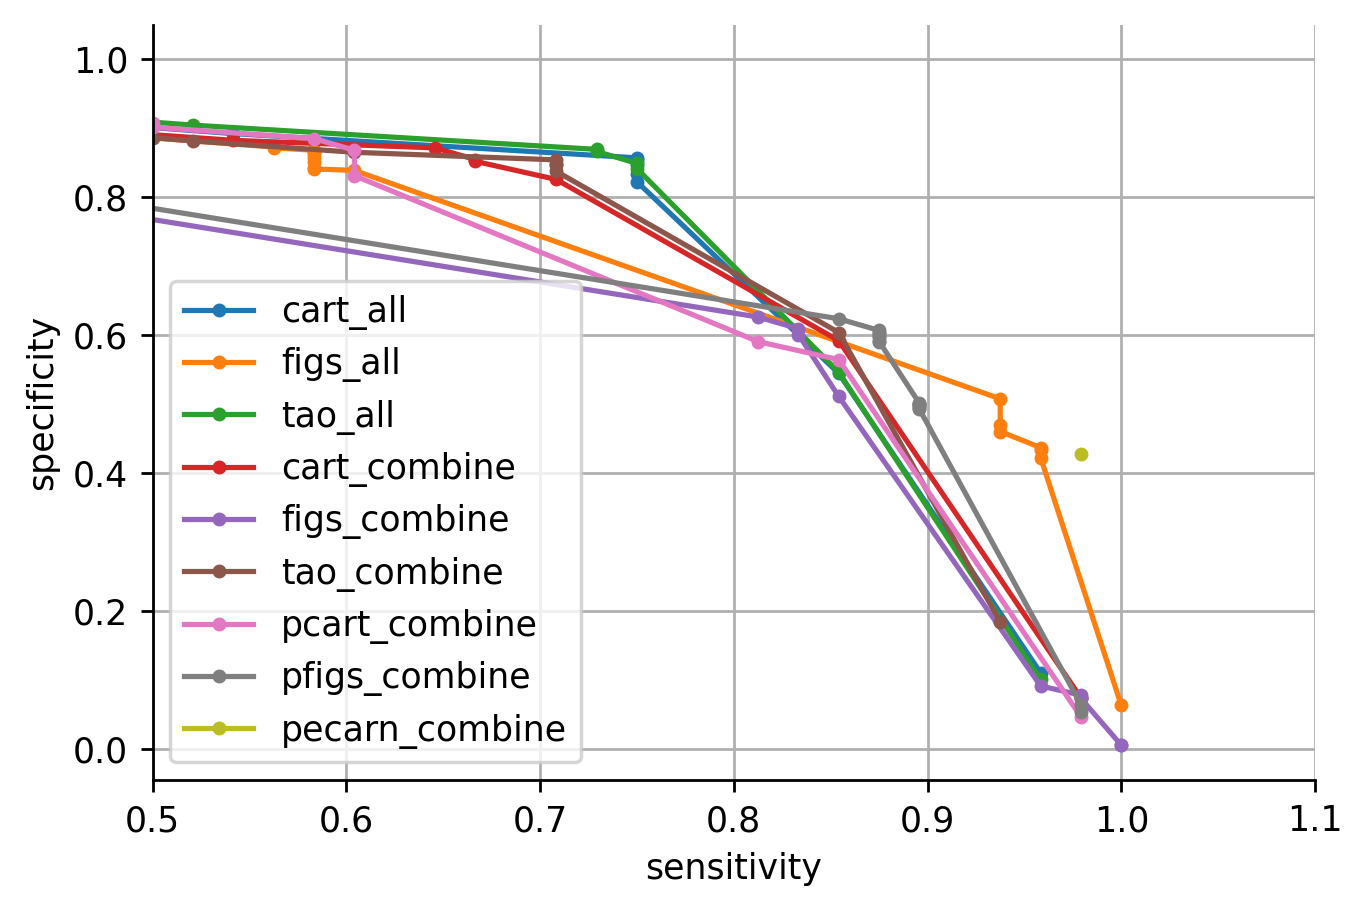

In [562]:
for model_name in ['cart_all', 'figs_all', 'tao_all', 'cart_combine', 'figs_combine', 'tao_combine', 'pcart_combine', 'pfigs_combine', 'pecarn_combine']:
    predict_and_save(best_models[f'{model_name}'], X_test, y_test, f'{model_name}', 'all')
plt.xlim(0.5, 1.1)
plt.legend()

100%|██████████| 11/11 [00:00<00:00, 1132.12it/s]


(0.5, 1.1)

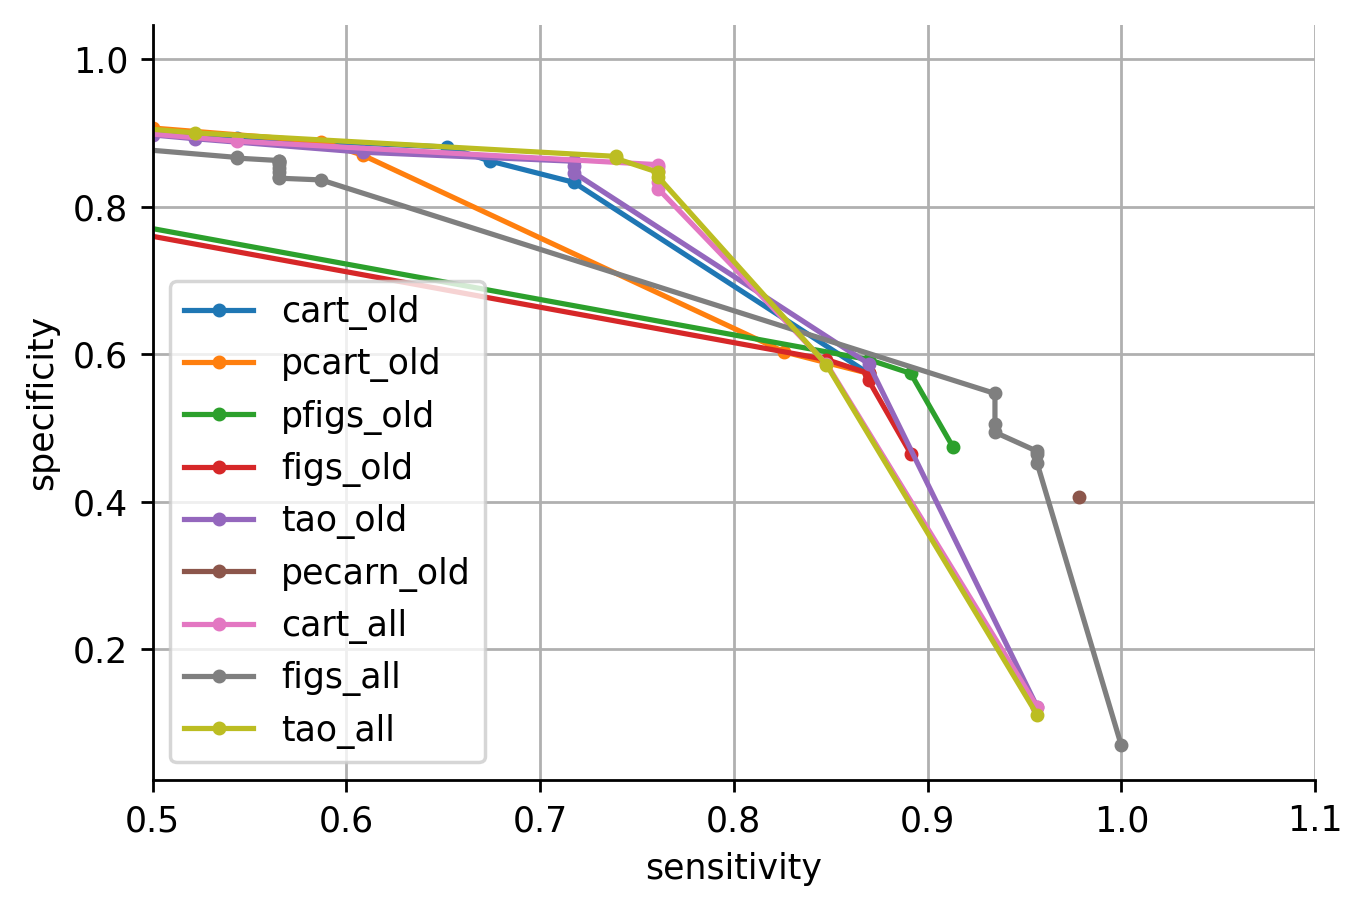

In [563]:
for model_name in ['cart_old', 'pcart_old', 'pfigs_old', 'figs_old', 'tao_old', 'pecarn_old', 'cart_all', 'figs_all', 'tao_all']:
    predict_and_save(best_models[f'{model_name}'], X_test_old, y_test_old, f'{model_name}', 'old')
plt.legend()
plt.xlim(0.5, 1.1)

100%|██████████| 8/8 [00:00<00:00, 685.82it/s]


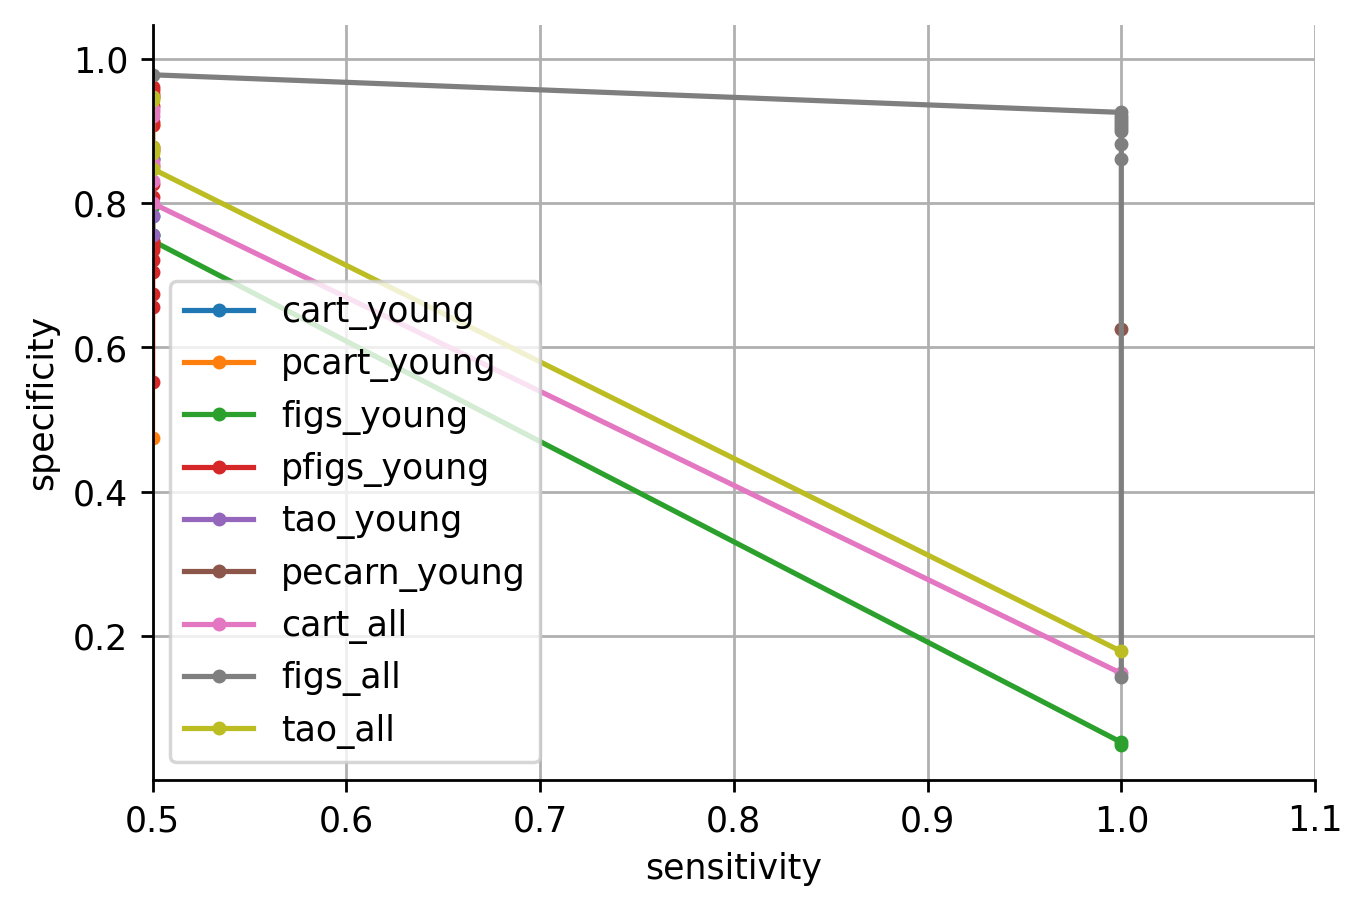

In [564]:
for model_name in ['cart_young', 'pcart_young', 'figs_young', 'pfigs_young', 'tao_young', 'pecarn_young', 'cart_all', 'figs_all', 'tao_all']:
    predict_and_save(best_models[f'{model_name}'], X_test_young, y_test_young, f'{model_name}', 'young')
plt.xlim(0.5, 1.1)
plt.legend()

In [565]:
pkl.dump(best_models, open(oj(RESULT_PATH, 'best_models.pkl'), 'wb'))

### Visualizing best models

In [567]:
def vizfigs(name):
    best_models[name].feature_names_ = feature_names
    print(best_models[name])

In [568]:
vizfigs('pfigs_old')

------------
AbdomenPain_no <= 0.500 (Tree #0 root)
	Val: 0.669 (leaf)
	AbdDistention_or_AbdomenPain_no <= 0.500 (split)
		Val: 0.663 (leaf)
		ThoracicTrauma_yes <= 0.500 (split)
			GCSScore <= 3.500 (split)
				Val: 0.928 (leaf)
				Val: 0.083 (leaf)
			Val: 0.345 (leaf)



In [569]:
vizfigs('pfigs_young')

------------
GCSScore <= 10.500 (Tree #0 root)
	Age <= 1.500 (split)
		Val: 0.720 (leaf)
		Val: 0.925 (leaf)
	AbdTenderDegree_None <= 0.500 (split)
		Val: 0.759 (leaf)
		VomitWretch_yes <= 0.500 (split)
			DistractingPain_yes <= 0.500 (split)
				MOI_unknown <= 0.500 (split)
					Val: 0.068 (leaf)
					Val: 0.467 (leaf)
				MOI_Fall down stairs <= 0.500 (split)
					ThoracicTender_yes <= 0.500 (split)
						Val: 0.187 (leaf)
						Val: 0.747 (leaf)
					Val: 0.870 (leaf)
			Val: 0.617 (leaf)

	+
AbdTrauma_yes <= 0.500 (Tree #1 root)
	ThoracicTrauma_no <= 0.500 (split)
		Val: 0.101 (leaf)
		MOI_unknown <= 0.500 (split)
			SeatBeltSign_unknown <= 0.500 (split)
				Val: -0.114 (leaf)
				Val: 0.220 (leaf)
			Val: -0.505 (leaf)
	Val: 0.172 (leaf)



In [570]:
vizfigs('figs_all')

------------
AbdomenPain_no <= 0.500 (Tree #0 root)
	Val: 0.658 (leaf)
	AbdDistention_or_AbdomenPain_yes <= 0.500 (split)
		ThoracicTrauma_yes <= 0.500 (split)
			MOI_Fall down stairs <= 0.500 (split)
				GCSScore <= 3.500 (split)
					Val: 0.924 (leaf)
					Age <= 16.500 (split)
						Val: 0.032 (leaf)
						Val: 0.295 (leaf)
				Val: 0.547 (leaf)
			GCSScore_Full_yes <= 0.500 (split)
				Val: 0.746 (leaf)
				RtCostalTender <= 2.500 (split)
					Age <= 3.500 (split)
						Val: 0.637 (leaf)
						Val: -0.030 (leaf)
					Val: 0.696 (leaf)
		Val: 0.662 (leaf)

	+
AbdTrauma_no <= 0.500 (Tree #1 root)
	Val: 0.157 (leaf)
	DecrBreathSound_no <= 0.500 (split)
		Val: 0.185 (leaf)
		AbdomenPain_no <= 0.500 (split)
			Val: -0.234 (leaf)
			Val: -0.002 (leaf)



### understanding propensity model

- main features that determine scores

In [571]:
nonzero_ind = np.nonzero(prop_models['L'].coef_[0])[0]
nonzero_ind_sorted = nonzero_ind[np.argsort(prop_models['L'].coef_[0][nonzero_ind])]
prop_model_coefs = pd.DataFrame(prop_models['L'].coef_[0][nonzero_ind_sorted], index=X_df_prop.columns[nonzero_ind_sorted])

In [572]:
important_prop_features = pd.concat((prop_model_coefs.iloc[:10], prop_model_coefs.iloc[-10:]))
important_prop_features.reset_index(inplace=True)
important_prop_features.columns = pd.Index(['Feature name', 'Coefficient'])
important_prop_features.style.background_gradient()

,Feature name,Coefficient
0,AbdomenPain_unknown,-1.643
1,MOI_Fall down stairs,-1.191
2,MOI_unknown,-0.758
3,ThoracicTender_unknown,-0.586
4,MOI_Object struck abdomen,-0.562
5,MOI_Fall from an elevation,-0.283
6,AbdTenderDegree_unknown,-0.239
7,ThoracicTrauma_unknown,-0.167
8,Hypotension_no,-0.163
9,GCSScore,-0.139


- distribution of scores

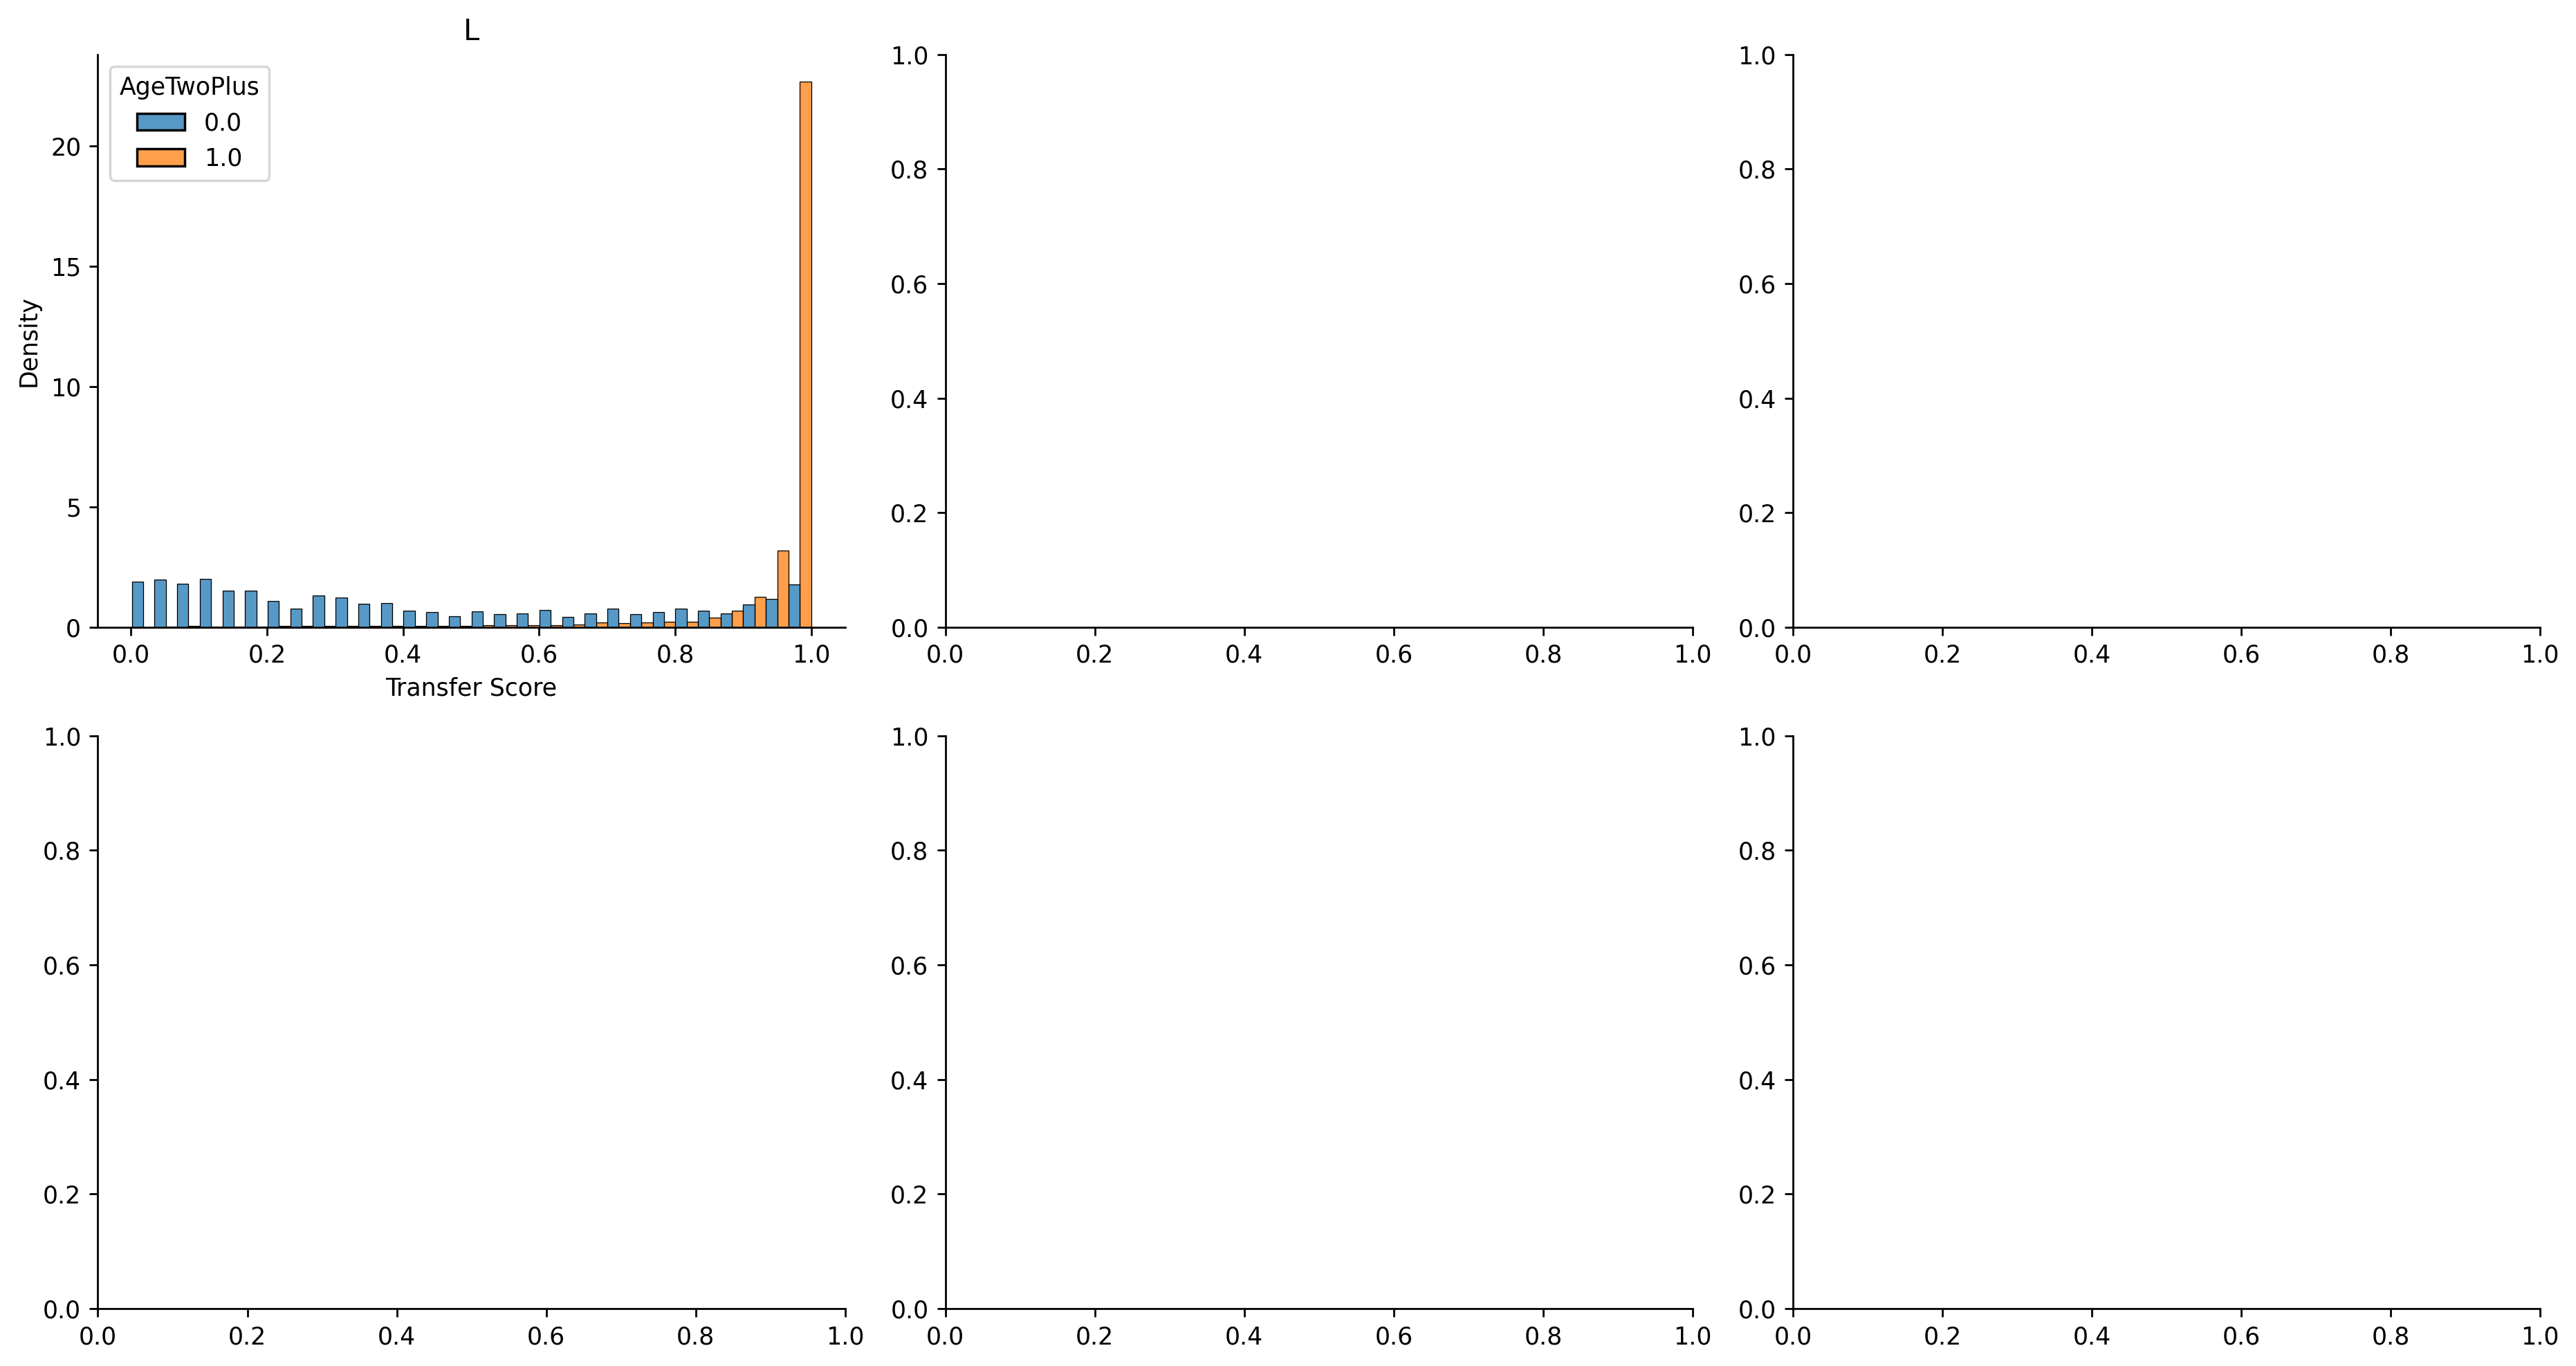

In [573]:
X_df_prop_raw_train_full, X_df_test = model_selection.train_test_split(X_df_prop_raw, test_size=0.2, random_state=SPLIT_SEED)

fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for k, pmodel in enumerate(prop_models):
    X_df_prop_raw_train_full['Transfer Score'] = prop_scores[f'{pmodel}_full']
    if DATASET == 'iai':
        X_df_prop_raw_train_full['AgeTwoPlus'] = X_df_prop_raw_train_full['Age<2_no']
    elif DATASET == 'csi':
        X_df_prop_raw_train_full['AgeTwoPlus'] = X_df_prop_raw_train_full['AgeInYears'] >= 2
    sns.histplot(data=X_df_prop_raw_train_full, x='Transfer Score', hue='AgeTwoPlus', 
        multiple='dodge', stat="density", common_norm=False, bins=30, ax=axes[k // 3, k % 3])
    axes[k // 3, k % 3].set_title(pmodel)
plt.tight_layout()

- relationship between scores and age in months

In [ ]:
X_df_prop_raw_train_full_younger = X_df_prop_raw_train_full[X_df_prop_raw_train_full['AgeinYears'] < 5]

In [ ]:
sns.scatterplot(data=X_df_prop_raw_train_full_younger, x='Transfer Score', y='AgeInMonth', hue = 'AgeTwoPlus', alpha=0.05, s=15)

- possible further analysis: dig into the cluster of patients with age over two with prop scores in (0.1, 0.4) seen above

### manual merging results

In [ ]:
# for i in range(10):
#     log_df = pd.read_csv(f'notebooks/transfertree/results/csi/log/seed_{i}/val.csv').set_index('Unnamed: 0')
#     gbp_df = pd.read_csv(f'notebooks/transfertree/results/csi/gbp/seed_{i}/val.csv').set_index('Unnamed: 0')
#     gbp_df_p = gbp_df.filter(regex='^P', axis=0)
#     gbp_df_p.index = gbp_df_p.index.str.replace('P', 'GBP')
#     pd.concat((log_df, gbp_df_p)).to_csv(f'notebooks/transfertree/results/csi/log/seed_{i}/val.csv')

In [ ]:
# for i in [0, 1, 2, 4, 7, 11, 12, 13, 15, 16]:
#     df = pd.read_csv(f'notebooks/transfertree/results/iai_2/seed_{i}/val.csv').set_index('Unnamed: 0')
#     df = df[~df.index.str.contains('<2_5') & ~df.index.str.contains('>2_5') & ~df.index.str.contains('all_5')]
#     df.to_csv(f'notebooks/transfertree/results/iai_2/seed_{i}/val.csv')

# val_df_group = val_df_group[~val_df_group.index.str.contains('<2_5') & ~val_df_group.index.str.contains('>2_5')]

In [ ]:
# df